In [ ]:
!pip install transformers datasets torch


In [ ]:
!pip install --upgrade scikit-learn


In [ ]:
import torch
import sklearn
import gc
import numpy as np
import pandas as pd
import torch.nn as nn
import psutil
from transformers import AutoModel, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
df= pd.read_csv("/content/chatgpt_reviews.csv")
df.head()  # Shows first few rows
df.info()  # Check data types and missing values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               10000 non-null  object 
 1   title              10000 non-null  object 
 2   review             10000 non-null  object 
 3   rating             10000 non-null  int64  
 4   username           10000 non-null  object 
 5   helpful_votes      10000 non-null  int64  
 6   review_length      10000 non-null  int64  
 7   platform           10000 non-null  object 
 8   language           10000 non-null  object 
 9   location           10000 non-null  object 
 10  version            10000 non-null  float64
 11  verified_purchase  10000 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 937.6+ KB


In [ ]:
# 🚀 Convert ratings into sentiment labels
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# ✅ Create the new sentiment label column
df["sentiment_label"] = df["rating"].apply(map_rating_to_sentiment)


In [ ]:
from imblearn.over_sampling import SMOTE

# ✅ Convert text to numerical vectors (Example: TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_vectorized = tfidf.fit_transform(df["review"]).toarray()

# ✅ Apply SMOTE on numeric embeddings
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, df["sentiment_label"])

print("✅ Dataset balanced using SMOTE!")


✅ Dataset balanced using SMOTE!


In [ ]:
print("Before SMOTE:", df["sentiment_label"].value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())


Before SMOTE: sentiment_label
0    4069
2    3988
1    1943
Name: count, dtype: int64
After SMOTE: sentiment_label
0    4069
2    4069
1    4069
Name: count, dtype: int64


In [ ]:
labels_resampled = np.array(y_resampled.tolist())  # ✅ Use resampled labels

class_weights_np = compute_class_weight("balanced", classes=np.unique(labels_resampled), y=labels_resampled)

# ✅ Convert to tensor for PyTorch and ensure it's on the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float).to(device)

print(f"Updated Class Weights After SMOTE: {class_weights_np}")  # 🚀 Verify weights
print(f"Class weights tensor device: {class_weights_tensor.device}") # 🚀 Verify device

Updated Class Weights After SMOTE: [1. 1. 1.]
Class weights tensor device: cuda:0


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ✅ Download required resources
nltk.download("stopwords")
nltk.download("wordnet")

# ✅ Initialize lemmatizer & stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# ✅ Add domain-specific stopwords for ChatGPT-related reviews
custom_stopwords = {"ai", "chatgpt", "bot", "response", "user"}  # Example additions
stop_words.update(custom_stopwords)

# ✅ Define text preprocessing function
def preprocess_text(text):
    text = text.lower()  # 🔹 Lowercase all text
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # 🔹 Remove special characters, but keep numbers
    text = re.sub(r"\s+", " ", text.strip())  # 🔹 Remove extra spaces
    text_tokens = text.split()

    # 🔹 Lemmatization with POS tagging for better accuracy
    lemmatized_text = " ".join([lemmatizer.lemmatize(word, pos='v') for word in text_tokens if word not in stop_words])

    return lemmatized_text

# ✅ Apply preprocessing to dataset
df["review_cleaned"] = df["review"].apply(preprocess_text)

# ✅ Check processed text
print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


         date                 title  \
0   2/15/2025            Impressive   
1  10/16/2024         Waste of Time   
2  10/16/2024         Waste of Time   
3  12/21/2024          Not Accurate   
4   3/23/2025  Fantastic Experience   

                                              review  rating       username  \
0  Mother former community upon vote fact. Sure s...       2          ybass   
1  General paper understand main. Or age half won...       5        glenn33   
2  Here situation his high stage. Agree certainly...       4       debbie27   
3  Rule court behind growth reality. Tonight whos...       1  hannahrussell   
4  Case opportunity season road write. Effort gre...       3        cnorton   

   helpful_votes  review_length platform language   location  version  \
0             68             78   Mobile       es     Canada      3.0   
1             71            193      Web       de      India      4.1   
2             66            184      Web       hi      India      4.1  

In [ ]:
from transformers import AutoTokenizer

# ✅ Load Pre-trained Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# ✅ Define Tokenization Function
def tokenize_text(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=256)

# ✅ Apply Tokenization Correctly
df["tokenized"] = df["review_cleaned"].apply(tokenize_text)

# ✅ Extract input IDs and attention mask from tokenized output
df["input_ids"] = df["tokenized"].apply(lambda x: x["input_ids"])
df["attention_mask"] = df["tokenized"].apply(lambda x: x["attention_mask"])

# ✅ Check the tokenized output
print(df[["input_ids", "attention_mask"]].head())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                           input_ids  \
0  [101, 2388, 2280, 2451, 2588, 3789, 2755, 2469...   
1  [101, 2236, 3259, 3305, 2364, 2287, 2431, 4687...   
2  [101, 3663, 2152, 2754, 5993, 5121, 2630, 4595...   
3  [101, 3627, 2457, 2369, 3930, 4507, 3892, 3005...   
4  [101, 2553, 4495, 2161, 2346, 4339, 3947, 2665...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  


In [ ]:
from transformers import AutoTokenizer

# ✅ Load Pre-trained Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# ✅ Define Tokenization Function with Dynamic Padding
def tokenize_text(text):
    return tokenizer(text, truncation=True, padding="longest", return_tensors="pt")

# ✅ Apply Tokenization
df["tokenized"] = df["review_cleaned"].apply(tokenize_text)

# ✅ Extract input IDs and attention mask from tokenized output
df["input_ids"] = df["tokenized"].apply(lambda x: x["input_ids"].squeeze().tolist())  # Convert tensor to list
df["attention_mask"] = df["tokenized"].apply(lambda x: x["attention_mask"].squeeze().tolist())  # Convert tensor to list

# ✅ Check tokenized text lengths before padding
df["review_length"] = df["review_cleaned"].apply(lambda x: len(x.split()))
df["token_length"] = df["input_ids"].apply(lambda x: sum(1 for i in x if i != 0))  # Count non-zero tokens

# ✅ Display statistics to confirm improvement
print("Text Length Stats:")
print(df[["review_length", "token_length"]].describe())  # Check min/max/mean lengths

# ✅ Check sample tokenized output
print(df[["input_ids", "attention_mask"]].head())


Text Length Stats:
       review_length  token_length
count   10000.000000  10000.000000
mean       19.743600     21.743600
std         4.915819      4.915819
min         3.000000      5.000000
25%        16.000000     18.000000
50%        20.000000     22.000000
75%        24.000000     26.000000
max        31.000000     33.000000
                                           input_ids  \
0  [101, 2388, 2280, 2451, 2588, 3789, 2755, 2469...   
1  [101, 2236, 3259, 3305, 2364, 2287, 2431, 4687...   
2  [101, 3663, 2152, 2754, 5993, 5121, 2630, 4595...   
3  [101, 3627, 2457, 2369, 3930, 4507, 3892, 3005...   
4  [101, 2553, 4495, 2161, 2346, 4339, 3947, 2665...   

                                      attention_mask  
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  

In [ ]:
import torch

# ✅ Convert tokenized inputs to uniform padded tensors
input_ids_tensor = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(ids, dtype=torch.long) for ids in df["input_ids"]],
    batch_first=True, padding_value=0
)

attention_mask_tensor = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(mask, dtype=torch.long) for mask in df["attention_mask"]],
    batch_first=True, padding_value=0
)

# ✅ Convert labels to a tensor
labels_tensor = torch.tensor(df["sentiment_label"].tolist(), dtype=torch.long)

print("✅ Successfully converted tokenized inputs to uniform tensors!")
print(f"Input IDs shape: {input_ids_tensor.shape}")
print(f"Attention Mask shape: {attention_mask_tensor.shape}")
print(f"Labels shape: {labels_tensor.shape}")


✅ Successfully converted tokenized inputs to uniform tensors!
Input IDs shape: torch.Size([10000, 33])
Attention Mask shape: torch.Size([10000, 33])
Labels shape: torch.Size([10000])


In [ ]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader

# ✅ Move tensors to CPU for DataLoader compatibility
input_ids_tensor = input_ids_tensor.cpu()
attention_mask_tensor = attention_mask_tensor.cpu()
labels_tensor = labels_tensor.cpu()

# ✅ Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ Define Dataset Class (Use CPU tensors to avoid pinning issues)
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids  # 🔹 Stay on CPU for DataLoader compatibility
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx]
        }

# ✅ Instantiate the Dataset with CPU tensors
dataset = SentimentDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)

# ✅ Define split sizes (80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# ✅ Perform dataset split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ✅ Define DataLoaders for efficient training (pin_memory removed)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ✅ Verify
print(f"Training Samples: {len(train_dataset)}")
print(f"Testing Samples: {len(test_dataset)}")


Training Samples: 8000
Testing Samples: 2000


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class SentimentClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SentimentClassifier, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name, return_dict=True)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(self.transformer.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)

        # ✅ Apply dropout before final classification
        logits = self.fc(self.dropout(output.last_hidden_state[:, 0, :].float()))

        probs = torch.nn.functional.softmax(logits, dim=-1)  # 🔹 Convert logits into probabilities

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)  # ✅ Apply smoothing

            loss = loss_fct(logits, labels.long())

            # ✅ Return the calculated loss along with logits and probabilities
            return {"loss": loss, "logits": logits, "probs": probs}

        # ✅ Return logits and probabilities during evaluation/prediction
        return {"logits": logits, "probs": probs}

# ✅ Load Model onto GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier("distilbert-base-uncased", num_classes=3)
model.to(device)


for param in list(model.transformer.parameters())[:4]:
    param.requires_grad = False  # 🔹 Allows upper layers to learn new patterns


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    run_name="sentiment_classifier_run",
    save_total_limit=2,
    save_steps=250,  # 🔹 More frequent saving
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    learning_rate=1e-7,  # 🔹 Adjusted for stability
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=4,
    save_strategy="steps",  # 🔹 More frequent model checkpoints
    eval_strategy="epoch",
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=50,  # 🔹 Less frequent logging
    fp16=True,  # 🔹 Speeds up training
    fp16_full_eval=True,  # 🔹 Optimizes evaluation speed
    report_to="none"  # 🔹 Prevents wandb from being used
)

print("✅ Training setup optimized!")


✅ Training setup optimized!


In [ ]:
!pip install --upgrade accelerate

In [ ]:
from accelerate.utils import write_basic_config

# ✅ Reset `AccelerateState` to fix the distributed training issue
write_basic_config()


Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [ ]:
from transformers import Trainer
from transformers import get_scheduler
from torch.optim import AdamW  # 🔹 Use PyTorch’s AdamW instead

# ✅ Initialize Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.1)

# ✅ Define Learning Rate Scheduler
lr_scheduler = get_scheduler(
    "cosine", optimizer=optimizer, num_warmup_steps=500, num_training_steps=10000
)
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

        outputs = model(**inputs)
        loss = outputs["loss"]

        # ✅ Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, lr_scheduler)  # ✅ Pass both optimizer & scheduler
)



In [ ]:
# 🚀 Start training
trainer.train()


Epoch,Training Loss,Validation Loss
1,1.086500,1.056928
2,1.076000,1.050166
3,1.084200,1.061156
4,1.077200,1.063439
5,1.062200,1.045551
6,1.062700,1.048349
7,1.057400,1.054854
8,1.059900,1.061659
9,1.020800,1.111717
10,0.990700,1.114897


TrainOutput(global_step=5000, training_loss=1.0543415016174316, metrics={'train_runtime': 718.9714, 'train_samples_per_second': 111.27, 'train_steps_per_second': 6.954, 'total_flos': 0.0, 'train_loss': 1.0543415016174316, 'epoch': 10.0})

In [ ]:
print(type(test_dataset))  # ✅ Should output `<class 'datasets.Dataset'>`


<class 'torch.utils.data.dataset.Subset'>


In [ ]:
import numpy as np
test_labels = np.array([test_dataset.dataset[i]["labels"] for i in test_dataset.indices])  # ✅ Speed boost


Epoch,Training Loss,Validation Loss
1,0.905200,1.166084
2,0.895800,1.214442
3,0.922700,1.223230
4,0.841000,1.300555


Type of predictions: <class 'transformers.trainer_utils.PredictionOutput'>
Type of predictions.predictions: <class 'tuple'>
Shape of predictions.predictions: No shape attribute


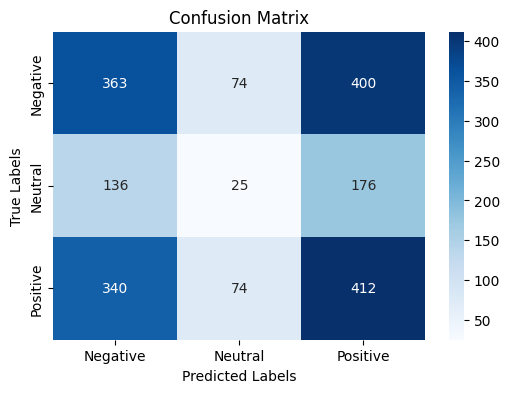

✅ Accuracy: 0.4000
✅ Precision: 0.3776
✅ Recall: 0.4000
✅ F1-Score: 0.3854

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.43      0.43       837
           1       0.14      0.07      0.10       337
           2       0.42      0.50      0.45       826

    accuracy                           0.40      2000
   macro avg       0.33      0.34      0.33      2000
weighted avg       0.38      0.40      0.39      2000



In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Predictions on test dataset
predictions = trainer.predict(test_dataset)

# Add these lines to inspect the structure of predictions
print(f"Type of predictions: {type(predictions)}")
print(f"Type of predictions.predictions: {type(predictions.predictions)}")
print(f"Shape of predictions.predictions: {predictions.predictions.shape if hasattr(predictions.predictions, 'shape') else 'No shape attribute'}")


import numpy as np
pred_labels = np.array(predictions.predictions[0]).argmax(axis=1)  # ✅ Ensures compatibility

# ✅ Compute evaluation metrics
accuracy = accuracy_score(test_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, pred_labels, average='weighted')

# ✅ Confusion Matrix visualization
conf_matrix = confusion_matrix(test_labels, pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(test_labels, pred_labels))

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

In [ ]:
%%writefile app.py

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import torch
from transformers import pipeline

# ✅ Load Sentiment Analysis Model
sentiment_pipeline = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

# ✅ Load and Process Your Dataset
@st.cache_data
def load_data():
    df = pd.read_csv("sentiment_data.csv")  # Replace with your dataset file
    return df

df = load_data()

# ✅ Streamlit App UI
st.title("Sentiment Analysis Dashboard")
st.header(":black[Analysis Based on User Reviews]")

# 📌 **Live Sentiment Prediction**
st.subheader("🔮 Predict Sentiment for Your Review")
user_review = st.text_area("Enter a review to analyze:")

if user_review:
    prediction = sentiment_pipeline(user_review)[0]["label"]

    # ✅ Map model output to "Positive," "Negative," or "Neutral"
    sentiment_mapping = {
        "POSITIVE": "Positive 😊",
        "NEGATIVE": "Negative 😠",
        "NEUTRAL": "Neutral 😐"
    }

    # ✅ Show prediction with proper sentiment label
    sentiment_result = sentiment_mapping.get(prediction, "Neutral 😐")
    st.write(f"**Predicted Sentiment:** {sentiment_result}")

    # ✅ Display Sentiment Color Coding
    if prediction == "POSITIVE":
        st.success("This review is positive! 😊")
    elif prediction == "NEGATIVE":
        st.error("This review is negative! 😠")
    else:
        st.warning("This review seems neutral. 😐")

# 📌 **Overall Sentiment Distribution**
st.subheader("Overall Sentiment of User Reviews")
df["sentiment"] = df["review"].apply(lambda x: sentiment_pipeline(x)[0]["label"])
sentiment_counts = df["sentiment"].value_counts()
st.bar_chart(sentiment_counts)

# 📌 **Sentiment vs. Rating**
st.subheader("How Does Sentiment Vary by Rating?")
rating_sentiment = df.groupby(["rating", "sentiment"]).size().unstack()
st.line_chart(rating_sentiment)

# 📌 **Most Associated Keywords Per Sentiment**
st.subheader("Most Common Keywords for Each Sentiment")
for sentiment_class in ["POSITIVE", "NEGATIVE"]:
    words = " ".join(df[df["sentiment"] == sentiment_class]["review"])
    wordcloud = WordCloud(width=500, height=300, background_color="white").generate(words)
    st.image(wordcloud.to_array())

st.write("✅ **Sentiment analysis results displayed successfully!**")


Writing app.py


In [ ]:
!npm install localtunnel


⠙⠹⠸⠼⠴⠦
added 22 packages in 1s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦

In [ ]:
!ngrok authtoken "2terU4zhNtE7gaJcw6zOfvfv0yM_5aGUqzHPuFd2fJTaWFfbv"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!cat /root/.config/ngrok/ngrok.yml


region: us
version: '2'
authtoken: 2terU4zhNtE7gaJcw6zOfvfv0yM_5aGUqzHPuFd2fJTaWFfbv


In [ ]:
!ngrok config add-authtoken 2terU4zhNtE7gaJcw6zOfvfv0yM_5aGUqzHPuFd2fJTaWFfbv


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Open a tunnel for Streamlit (port 8501)
public_url = ngrok.connect(8501, "http")
print("✅ Your Streamlit App is accessible at:", public_url)


✅ Your Streamlit App is accessible at: NgrokTunnel: "https://face-34-125-254-251.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.254.251:8501

  Stopping...
  Stopping...
Exception ignored in atexit callback: <function shutdown at 0x7b6bac939440>
Traceback (most recent call last):
  File "/usr/lib/python3.11/logging/__init__.py", line 2194, in shutdown
    h.release()
  File "/usr/lib/python3.11/logging/__init__.py", line 929, in release
    def release(self):

  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/bootstrap.py", line 44, in signal_handler
    server.stop()
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/server/server.py", line 469, in stop
    self._runtime.stop()
  File "/usr/local/lib/python3.11/dist-packages/streamlit/runtime/runtime.py", line 324, in stop
    async_objs.eventloop.call_soon_threadsafe(stop_on_eventloop)
  File "/usr/lib/python3.11/asyncio/base_events.py", line 807, in call_soon_threadsafe
    s

In [ ]:
import torch

# ✅ Save the model weights
torch.save(model.state_dict(), "sentiment_model.pth")

# ✅ Save the tokenizer separately if using Hugging Face
tokenizer.save_pretrained("sentiment_tokenizer")


('sentiment_tokenizer/tokenizer_config.json',
 'sentiment_tokenizer/special_tokens_map.json',
 'sentiment_tokenizer/vocab.txt',
 'sentiment_tokenizer/added_tokens.json',
 'sentiment_tokenizer/tokenizer.json')

In [ ]:
from google.colab import files
files.download("sentiment_model.pth")  # ✅ Downloads model weights


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>